In [2]:
import pandas as pd
import numpy as np

In [3]:
cons1 = pd.read_csv(r'/home/davo/projects/COMP598_Project/data/conservative1_coded.tsv' , sep='\t')
cons2 = pd.read_excel(r'/home/davo/projects/COMP598_Project/data/conservative2_coded.xlsx')
cons3 = pd.read_csv(r'/home/davo/projects/COMP598_Project/data/conservative3_coded.tsv' , sep='\t')

In [4]:
pols1 = pd.read_csv(r'/home/davo/projects/COMP598_Project/data/politics1_coded.tsv' , sep='\t')
pols2 = pd.read_excel(r'/home/davo/projects/COMP598_Project/data/politics2_coded.xlsx')
pols3 = pd.read_csv(r'/home/davo/projects/COMP598_Project/data/politics3_coded.tsv' , sep='\t')

In [5]:
# print(f"Cons1 value counts: \n{cons1['coding'].value_counts(dropna=False)}");
# print(f"Cons2 alue counts: \n{cons2['coding'].value_counts(dropna=False)}");
# print(f"Cons3 value counts: \n{cons3['coding'].value_counts(dropna=False)}");

In [6]:
# print(f"Pols1 value counts: \n{pols1['coding'].value_counts(dropna=False)}");
# print(f"Pols2 value counts: \n{pols2['coding'].value_counts(dropna=False)}");
# print(f"Pols3 value counts: \n{pols3['coding'].value_counts(dropna=False)}");

In [7]:
cons_posts = pd.concat([cons1, cons2, cons3], ignore_index=True).drop_duplicates(subset=['Name']).reset_index(drop=True)
pols_posts = pd.concat([pols1, pols2, pols3], ignore_index=True).drop_duplicates(subset=['Name']).reset_index(drop=True)


In [8]:
#turn all codings that are not (f, v, l, t, r, c) into N
def keep_6_categories(posts):
    indices_of_other_letters = posts['coding'].apply(lambda letter: letter not in ['f', 'v', 'l', 't', 'r', 'c'])
    posts.loc[indices_of_other_letters, 'coding'] = 'N'
    return posts

cons_posts = keep_6_categories(cons_posts).drop(columns=['Name'])
pols_posts = keep_6_categories(pols_posts).drop(columns=['Name'])

print(f"Conservative posts value counts: \n{cons_posts['coding'].value_counts(dropna=False)}");
print(f"Politics posts value counts: \n{pols_posts['coding'].value_counts(dropna=False)}");

Conservative posts value counts: 
l    130
t    111
f     60
v     59
N     50
c     22
r     20
Name: coding, dtype: int64
Politics posts value counts: 
t    280
N    134
l    118
v    104
f     75
c     45
r     30
Name: coding, dtype: int64


In [35]:
cons_engagement_percentages_per_category = cons_posts['coding'].value_counts(dropna=False) / sum(cons_posts['coding'].value_counts(dropna=False))
pols_engagement_percentages_per_category = pols_posts['coding'].value_counts(dropna=False) / sum(pols_posts['coding'].value_counts(dropna=False))
engagement_per_category = pd.concat([cons_engagement_percentages_per_category, pols_engagement_percentages_per_category], axis=1)
engagement_per_category.columns = ["conservative", "politics"]
engagement_per_category = engagement_per_category.rename(index = {'l':'Lawsuits', 't':'Transition', 'f': "Foreign", 'v': "Voting", 'c':'Covid', 'r': 'Racism/Minorities', 'N':'N\A'})
engagement_per_category

,conservative,politics
Lawsuits,0.287611,0.150127
Transition,0.245575,0.356234
Foreign,0.132743,0.095420
Voting,0.130531,0.132316
N\A,0.110619,0.170483
Covid,0.048673,0.057252
Racism/Minorities,0.044248,0.038168


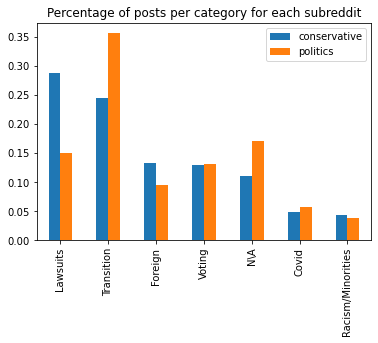

In [38]:
engagement_per_category.plot.bar(title='Percentage of posts per category for each subreddit')

In [39]:
def compute_tf_grouped_by_coding(posts):
    #replace all non-letters by a space and make every word of every sentence into a seperate row
    posts['title'] = posts['title'].str.replace('[^a-zA-Z]', ' ').str.split()
    posts = posts.explode('title', ignore_index=True).rename(columns={'title': 'words'})
    #for each coding, count the number of occurences of each word
    tfs = posts.groupby(['coding', 'words']).size().to_frame('tf')
    #sort the count column within each coding 
    tfs = tfs.sort_values(['coding', 'tf'], ascending=[True, False])
    return tfs

cons_tfs = compute_tf_grouped_by_coding(cons_posts)
pols_tfs = compute_tf_grouped_by_coding(pols_posts)

In [40]:
idx = pd.IndexSlice
pols_tfs.loc[idx['l', :, :]].iloc[:10, :]
cons_tfs.loc[idx['N' :, :]].iloc[:10, :]

tf
coding words    
N      Biden  27
       Trump  26
       to     18
       Joe    13
       the    12
       for    10
       s       9
       in      8
       of      8
       t       8

In [41]:
#number of documents each word appears in (we have 14 documents)
a = cons_tfs.index.get_level_values(1).value_counts()
b = pols_tfs.index.get_level_values(1).value_counts()
#idf scores for each word 
idf = a.add(b, fill_value=0).to_frame().sort_values(['words'], ascending=False).rename(columns={'words': 'idf'})
idf['idf'] = np.log(14 / idf['idf'] )
idf.index.ncons_tfsames = ['words']
idf

,idf
to,0.000000
at,0.000000
for,0.000000
a,0.000000
of,0.000000
...,...
Tweeting,2.639057
Create,2.639057
Crazy,2.639057
Cracks,2.639057


In [42]:
#create dictionaries that will hold the tf-idfs for each category
cons_tf_idfs = {}
for category in ['N', 'l', 'f', 'c', 'v', 'r', 't']:
    cons_tf_idfs[category] = cons_tfs.loc[idx[category], 'tf'].multiply(idf['idf'], fill_value=0, axis=0).sort_values(ascending=False)
    
pols_tf_idfs = {}
for category in ['N', 'l', 'f', 'c', 'v', 'r', 't']:
     pols_tf_idfs[category] = pols_tfs.loc[idx[category], 'tf'].multiply(idf['idf'], fill_value=0, axis=0).sort_values(ascending=False)

In [43]:
# pols_tf_idfs and cons_tf_idfs are the tf-idf score dictionaries
#to see the scores of a specific category, enter the letter below:

In [86]:
list(pols_tf_idfs['N'][:20].index)[:10]

['Thanksgiving',
 'Eve',
 'Lame',
 'down',
 'address',
 'unity',
 'd',
 'Night',
 'Melania',
 'mine']

In [85]:
list(cons_tf_idfs['f'][:20].index)[:10]

['China',
 'Flynn',
 'Michael',
 'pardons',
 'Chinese',
 'Afghanistan',
 'Iraq',
 'security',
 'Foreign',
 'Staffer']